In [1]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 사원 퇴사 / 근속 데이터
-> 근무 중 인원, 퇴사 인원 파악

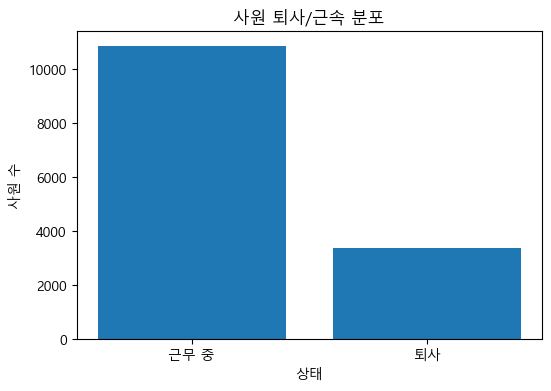

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform

if platform.system() == 'Darwin' :
    plt.rcParams["font.family"] = "AppleGothic"
else :
    plt.rcParams["font.family"] = "Malgun Gothic"
    
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
data = pd.read_csv('employee_churn.csv')

status = data['status'].value_counts()

plt.figure(figsize=(6, 4))

plt.bar(['근무 중', '퇴사'], status)
plt.title('사원 퇴사/근속 분포')
plt.xlabel('상태')
plt.ylabel('사원 수')
plt.show()


## 결측 값 처리

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 'department' 열의 결측치 삭제
if 'department' in data.columns:
    data = data.drop('department', axis=1)


# 'filed_complaint'과 'recently_promoted' 컬럼 데이터의 결측값을 0으로 채우기
data['filed_complaint'] = data['filed_complaint'].fillna(0)
data['recently_promoted'] = data['recently_promoted'].fillna(0)

# 'tenure'컬럼 데이터 근속 연수를 구하므로 결측값을 1으로 채우기
data['tenure'] = data['tenure'].fillna(1)

# 'last_evaluation', 'satisfaction' 결측치를 평균값으로 대체
data['last_evaluation'] = data['last_evaluation'].fillna(data['last_evaluation'].mean())
data['satisfaction'] = data['satisfaction'].fillna(data['satisfaction'].mean())


## 'status'컬럼 데이터 0,1로 변환
data['status'] = data['status'].replace({'Left': 1, 'Employed': 0})

# print(data['department'].dtypes)

# 범주형 변수를 Label Encoding 또는 One-Hot Encoding으로 변환
categorical_columns = data.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # 각 열의 인코더 저장 (나중에 해석 가능)

# 수치형 데이터를 표준화
scaler = StandardScaler()
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

X = data.drop('status', axis=1)  # 이탈 여부 열을 제외한 데이터
y = data['status']  # 이탈 여부 열만 선택

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


data

C:\Users\Playdata\AppData\Local\Temp\ipykernel_10964\3317622628.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['status'] = data['status'].replace({'Left': 1, 'Employed': 0})


,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,0.415794,-0.410869,1.311357,0.180508,-0.146652,-0.561893,0.838210,1.789069,1.038047
1,0.631493,-0.410869,0.000000,-0.617524,-0.146652,-0.561893,0.856885,-0.558950,-0.991378
2,-0.309740,-0.410869,0.430327,-0.617524,-0.146652,1.040992,0.858668,-0.558950,-0.314903
3,0.121659,-0.410869,-0.873391,0.180508,-0.146652,-0.561893,-0.789711,-0.558950,-0.991378
4,0.964847,-0.410869,0.775231,-0.617524,-0.146652,-0.561893,0.633869,-0.558950,-0.314903
...,...,...,...,...,...,...,...,...,...
14244,-0.427394,-0.410869,0.106359,0.978540,-0.146652,-0.561893,-1.438586,-0.558950,1.038047
14245,1.121719,-0.410869,-0.488557,-0.617524,-0.146652,-0.561893,0.992161,-0.558950,-0.991378
14246,0.631493,2.433868,0.789944,0.978540,-0.146652,1.040992,1.115554,1.789069,1.038047
14247,-1.368627,-0.410869,0.236757,0.180508,-0.146652,1.040992,0.080400,-0.558950,-0.314903


In [18]:
## 랜덤포레스트 모델

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# 종속 변수와 독립 변수 분리
X = data.drop('status', axis=1)
y = data['status'].astype(int)

# 학습 데이터와 테스트 데이터 분할 (stratify=y 추가)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 랜덤 포레스트 모델
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 랜덤 포레스트 모델 평가
y_pred_rf = rf.predict(X_test)
# print("Random Forest Performance:")
# print(classification_report(y_test, y_pred_rf))

In [19]:
# 성능 평가 함수 정의
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

# 2. 랜덤 포레스트 평가
print("\nRandom Forest Performance:")
evaluate_model(rf, X_test, y_test)

# 3. 랜덤 포레스트 하이퍼파라미터 튜닝 (GridSearchCV)
# 튜닝할 하이퍼파라미터 범위 정의
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV 활용
randomsearch = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=50, cv=3, n_jobs=-1, scoring='f1', random_state=42)
randomsearch.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 성능 출력
print("\nBest Hyperparameters for Random Forest:", randomsearch.best_params_)
bestrf = randomsearch.best_estimator_
print("\nBest Random Forest Performance after tuning:")
evaluate_model(bestrf, X_test, y_test)


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2172
           1       0.98      0.93      0.95       678

    accuracy                           0.98      2850
   macro avg       0.98      0.96      0.97      2850
weighted avg       0.98      0.98      0.98      2850

Accuracy: 0.9778947368421053
Precision: 0.9782270606531882
Recall: 0.9277286135693216
F1 Score: 0.9523088569265707

Best Hyperparameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}

Best Random Forest Performance after tuning:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2172
           1       0.98      0.92      0.95       678

    accuracy                           0.98      2850
   macro avg       0.98      0.96      0.97      2850
weighted avg       0.98      0.98      0.98      2850

Accuracy: 0.9768421052631578
P

Confusion Matrix:


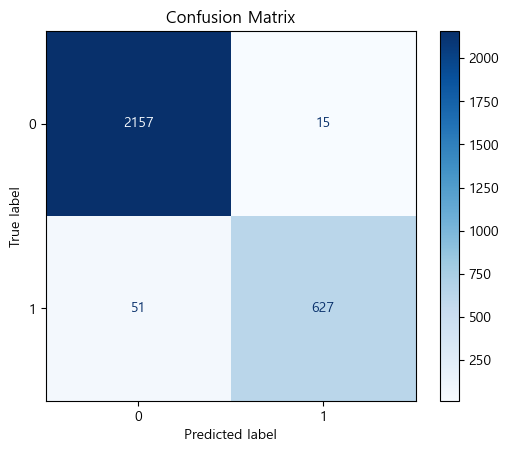

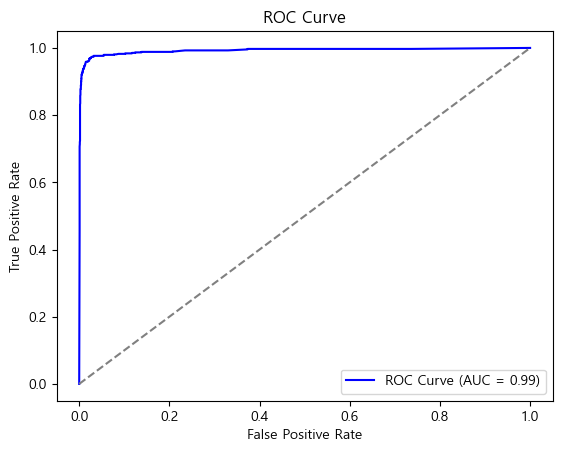

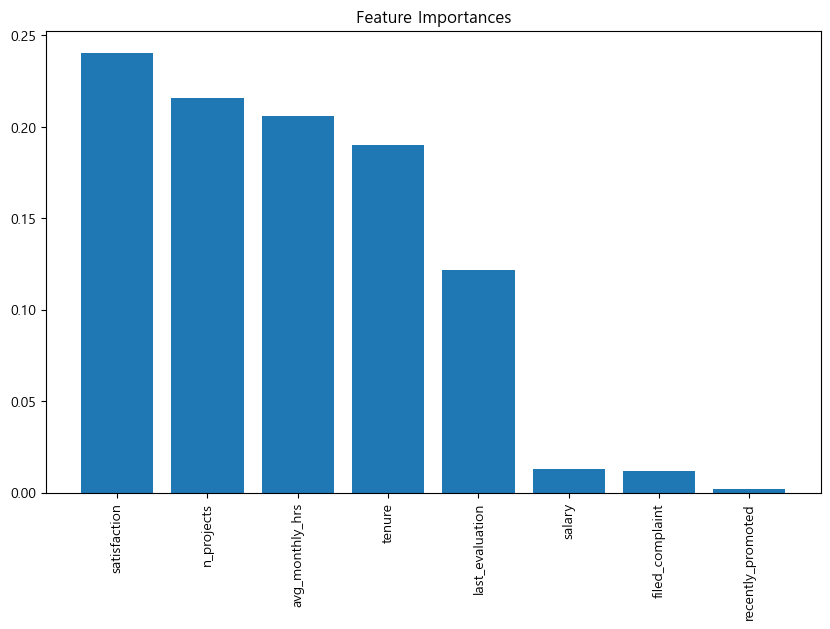

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# 최적 모델을 평가하는 함수
def evaluate_and_visualize_model(model, X_test, y_test):
    # 예측 수행
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # 혼동 행렬
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # ROC 곡선 및 AUC 점수
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("Model does not support probability prediction for ROC Curve.")

    # 특성 중요도 (랜덤 포레스트, 그라디언트 부스팅 등 트리 기반 모델만 해당)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        features = X_test.columns
        indices = importances.argsort()[::-1]  # 중요도 순서로 정렬

        plt.figure(figsize=(10, 6))
        plt.title("Feature Importances")
        plt.bar(range(len(indices)), importances[indices], align="center")
        plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
        plt.show()
    else:
        print("Feature importance is not available for this model.")

# 최종 평가: 최적화된 모델을 평가하고 시각적으로 분석
evaluate_and_visualize_model(bestrf, X_test, y_test)  # 'best_rf'는 최적화된 모델

In [21]:
import joblib

joblib.dump(rf, 'employee_churn_model.pkl')
print("Model saved as 'employee_churn_model.pkl'")

Model saved as 'employee_churn_model.pkl'
